## 1) Setup & Reproducibility

In [1]:

# Core
import os, math, time, random, json
from typing import Tuple, Dict, List

# Numerics
import numpy as np

# Torch & vision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms, models

# Visualization
import matplotlib.pyplot as plt

# Dimensionality reduction
from sklearn.manifold import TSNE
try:
    import umap
    HAVE_UMAP = True
except Exception:
    HAVE_UMAP = False

# Reproducibility helpers
def set_seed(seed: int = 1337, deterministic: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  # deterministic > fastest algo
    else:
        torch.backends.cudnn.benchmark = True   # allow fastest algo search

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# You can toggle deterministic here
set_seed(42, deterministic=True)


Device: cuda


## 2) Dataset & Dataloaders

In [2]:

# Choose dataset: 'CIFAR10' or 'STL10'
DATASET = "CIFAR10"

# Train/eval hyperparams (safe defaults)
BATCH_SIZE = 128
NUM_WORKERS = 2

# Data roots
DATA_ROOT = "./data"

# Transforms: ResNet expects 224x224 and ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
test_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

if DATASET.upper() == "CIFAR10":
    train_set = datasets.CIFAR10(DATA_ROOT, train=True, download=True, transform=train_tfms)
    test_set  = datasets.CIFAR10(DATA_ROOT, train=False, download=True, transform=test_tfms)
    NUM_CLASSES = 10
elif DATASET.upper() == "STL10":
    train_set = datasets.STL10(DATA_ROOT, split="train", download=True, transform=train_tfms)
    test_set  = datasets.STL10(DATA_ROOT, split="test", download=True, transform=test_tfms)
    NUM_CLASSES = 10
else:
    raise ValueError("Unsupported dataset. Use 'CIFAR10' or 'STL10'.")

# Optionally carve a validation set from train
VAL_RATIO = 0.1
val_size = int(len(train_set) * VAL_RATIO)
train_size = len(train_set) - val_size
train_set, val_set = random_split(train_set, [train_size, val_size],
                                  generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_set), len(val_set), len(test_set)


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


(45000, 5000, 10000)

## 3) Models — ResNet‑152 (Pretrained vs Random Init)

In [3]:

def make_resnet152(pretrained: bool, num_classes: int):
    # torchvision>=0.13 uses weights arg; handle both styles
    try:
        model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1 if pretrained else None)
    except Exception:
        model = models.resnet152(pretrained=pretrained)
    # Replace classifier
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model

pretrained_model = make_resnet152(pretrained=True,  num_classes=NUM_CLASSES).to(DEVICE)
random_model     = make_resnet152(pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)

sum_params = lambda m: sum(p.numel() for p in m.parameters())
print("Params (pretrained):", sum_params(pretrained_model))
print("Params (random):    ", sum_params(random_model))


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:01<00:00, 236MB/s]


Params (pretrained): 58164298
Params (random):     58164298


## 4) Feature Hierarchies (Early / Mid / Late)

In [4]:

# We tap into ResNet blocks:
# early  -> layer1
# middle -> layer3
# late   -> avgpool (before fc)
class FeatureHook:
    def __init__(self, module):
        self.features = None
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, inp, out):
        with torch.no_grad():
            self.features = out.detach()
    def close(self):
        self.hook.remove()

def attach_hooks(m: nn.Module):
    hooks = {}
    hooks['early']  = FeatureHook(m.layer1)
    hooks['middle'] = FeatureHook(m.layer3)
    hooks['late']   = FeatureHook(m.avgpool)
    return hooks

hooks = attach_hooks(pretrained_model.eval())

@torch.no_grad()
def extract_batch_features(model, images):
    _ = model(images)  # forward triggers hooks
    feats = {
        'early':  hooks['early'].features,
        'middle': hooks['middle'].features,
        'late':   hooks['late'].features,
        'logits': model.fc.weight.new_zeros((images.size(0), NUM_CLASSES))  # placeholder
    }
    return feats

# Sanity: run one batch
pretrained_model.eval()
images, labels = next(iter(val_loader))
images = images.to(DEVICE)
feats = extract_batch_features(pretrained_model, images)
{ k: tuple(v.shape) for k,v in feats.items() if k!='logits' }


{'early': (128, 256, 56, 56),
 'middle': (128, 1024, 14, 14),
 'late': (128, 2048, 1, 1)}

## 5) Visualization — t‑SNE / UMAP of Features

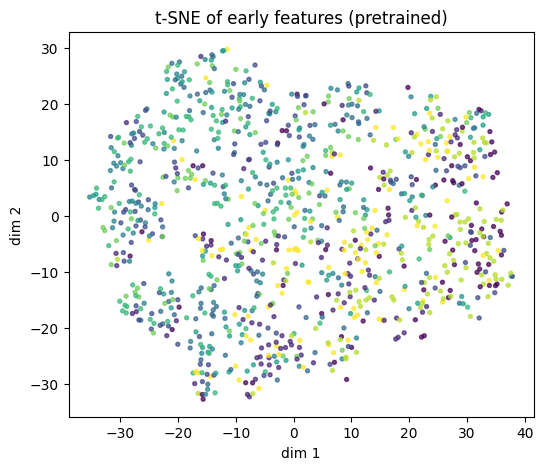

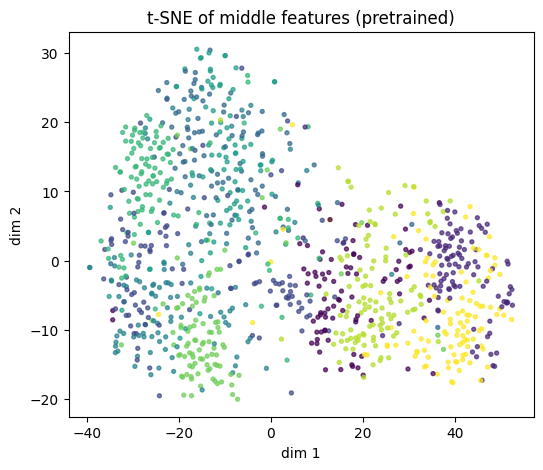

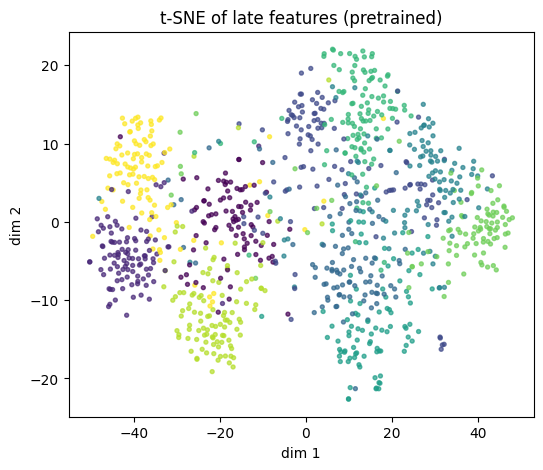

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


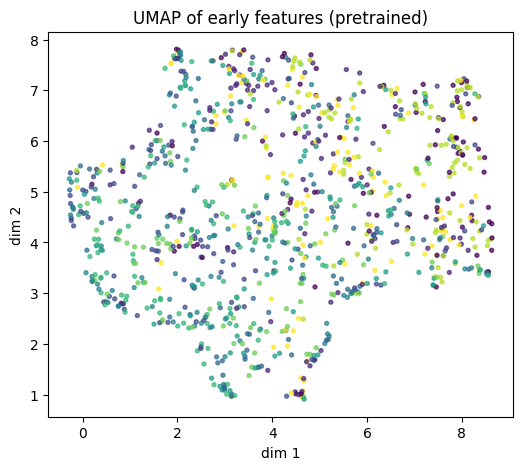

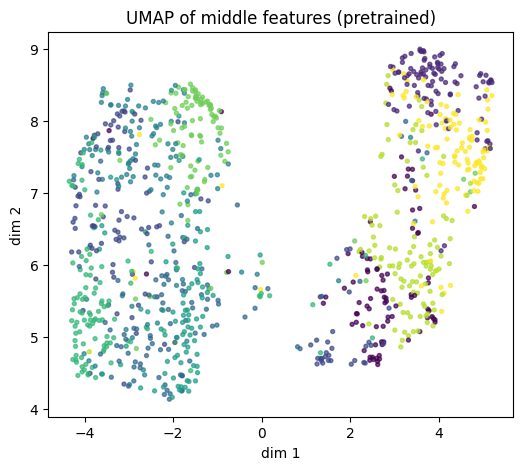

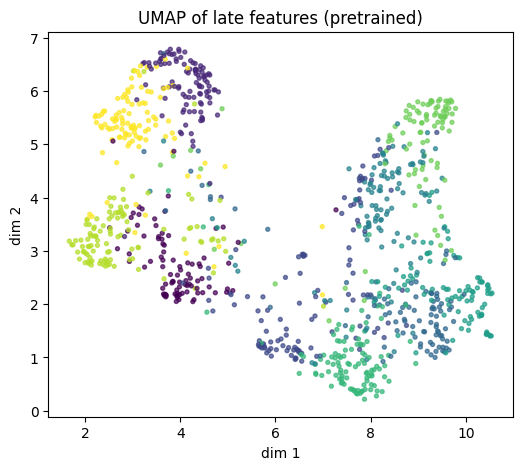

In [5]:

@torch.no_grad()
def collect_features(model, loader, max_batches: int = 10):
    model.eval()
    # Attach temporary hooks for this call
    tmp_hooks = attach_hooks(model)
    all_feats = {"early": [], "middle": [], "late": []}
    all_labels = []
    seen = 0
    for i, (x,y) in enumerate(loader):
        x = x.to(DEVICE)
        _ = model(x)
        # Pool spatial dims for early/middle to get vectors
        e = tmp_hooks['early'].features
        m = tmp_hooks['middle'].features
        l = tmp_hooks['late'].features  # already pooled (N,2048,1,1)

        e = F.adaptive_avg_pool2d(e, 1).squeeze(-1).squeeze(-1)
        m = F.adaptive_avg_pool2d(m, 1).squeeze(-1).squeeze(-1)
        l = l.view(l.size(0), -1)

        all_feats["early"].append(e.cpu())
        all_feats["middle"].append(m.cpu())
        all_feats["late"].append(l.cpu())
        all_labels.append(y)

        seen += x.size(0)
        if max_batches is not None and i+1 >= max_batches: break

    for k in all_feats:
        all_feats[k] = torch.cat(all_feats[k], dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    # Clean up hooks
    for h in tmp_hooks.values(): h.close()
    return all_feats, all_labels

# Collect (use a few batches for speed; raise max_batches for full set)
viz_feats, viz_labels = collect_features(pretrained_model, val_loader, max_batches=8)

def run_tsne(X, n=2, perp=30, seed=42):
    return TSNE(n_components=n, perplexity=perp, learning_rate="auto", init="pca", random_state=seed).fit_transform(X)

def plot_scatter(Z, y, title):
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=y, s=8, alpha=0.7)
    plt.title(title)
    plt.xlabel("dim 1"); plt.ylabel("dim 2")
    plt.show()

# t-SNE for each level
for level in ["early","middle","late"]:
    Z = run_tsne(viz_feats[level], perp=30)
    plot_scatter(Z, viz_labels, f"t‑SNE of {level} features (pretrained)")

# Optional: UMAP
if HAVE_UMAP:
    reducer = umap.UMAP(n_components=2, random_state=42)
    for level in ["early","middle","late"]:
        Z = reducer.fit_transform(viz_feats[level])
        plot_scatter(Z, viz_labels, f"UMAP of {level} features (pretrained)")
else:
    print("UMAP not installed — skipping.")


## 6) Transfer Learning Experiments

In [7]:
# Utilities: accuracy, train/eval loops
import copy

def accuracy(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def eval_model(model, loader, loss_fn):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = loss_fn(logits, y)
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)
    return correct/total, total_loss/total

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3, weight_decay=1e-4, finetune=False):
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best = {"val_acc": 0.0, "state": None}
    for ep in range(1, epochs+1):
        model.train()
        t0 = time.time()
        for x,y in train_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = loss_fn(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()
        va, vl = eval_model(model, val_loader, loss_fn)
        dt = time.time() - t0
        print(f"Epoch {ep:02d}/{epochs} | val_acc={va:.4f} val_loss={vl:.4f} | {dt:.1f}s")
        if va > best["val_acc"]:
            best["val_acc"] = va
            best["state"] = {k:v.cpu() for k,v in model.state_dict().items()}
    # restore best
    if best["state"] is not None:
        model.load_state_dict({k:v.to(DEVICE) for k,v in best["state"].items()})
    test_acc, test_loss = eval_model(model, test_loader, nn.CrossEntropyLoss())
    return best["val_acc"], test_acc

# A) Linear probing on frozen backbone: pretrained vs random-init
EPOCHS_LINEAR = 5

def clone_backbone_with_linear(model_src):
    model = copy.deepcopy(model_src)
    # Freeze all but final fc
    for p in model.parameters():
        p.requires_grad = False
    for p in model.fc.parameters():
        p.requires_grad = True
    return model

lin_pre = clone_backbone_with_linear(pretrained_model).to(DEVICE)
lin_rand = clone_backbone_with_linear(random_model).to(DEVICE)

print("== Linear probing (frozen backbone) : PRETRAINED ==")
va_pre, ta_pre = train_model(lin_pre, train_loader, val_loader, epochs=EPOCHS_LINEAR, lr=5e-3, weight_decay=1e-4)
print("== Linear probing (frozen backbone) : RANDOM-INIT ==")
va_rand, ta_rand = train_model(lin_rand, train_loader, val_loader, epochs=EPOCHS_LINEAR, lr=5e-3, weight_decay=1e-4)

print(f"[Linear] Pretrained  -> val_acc={va_pre:.4f}, test_acc={ta_pre:.4f}")
print(f"[Linear] Random-init -> val_acc={va_rand:.4f}, test_acc={ta_rand:.4f}")

== Linear probing (frozen backbone) : PRETRAINED ==
Epoch 01/5 | val_acc=0.7762 val_loss=0.6591 | 73.3s
Epoch 02/5 | val_acc=0.7602 val_loss=0.7279 | 73.9s
Epoch 03/5 | val_acc=0.7930 val_loss=0.6133 | 73.3s
Epoch 04/5 | val_acc=0.7512 val_loss=0.7852 | 73.7s
Epoch 05/5 | val_acc=0.7806 val_loss=0.6447 | 72.8s
== Linear probing (frozen backbone) : RANDOM-INIT ==
Epoch 01/5 | val_acc=0.1252 val_loss=2.5631 | 72.8s
Epoch 02/5 | val_acc=0.1362 val_loss=2.9170 | 73.0s
Epoch 03/5 | val_acc=0.1504 val_loss=3.0887 | 73.5s
Epoch 04/5 | val_acc=0.1184 val_loss=2.7587 | 73.2s
Epoch 05/5 | val_acc=0.1284 val_loss=2.7280 | 73.0s
[Linear] Pretrained  -> val_acc=0.7930, test_acc=0.8040
[Linear] Random-init -> val_acc=0.1504, test_acc=0.1473


### 6B) Fine‑tune Last Block vs Full Backbone

In [8]:

# Helper to set requires_grad for last block or full net
def unfreeze_last_block(model):
    # freeze all first
    for p in model.parameters():
        p.requires_grad = False
    # unfreeze fc + layer4 (last block)
    for p in model.layer4.parameters():
        p.requires_grad = True
    for p in model.fc.parameters():
        p.requires_grad = True
    return model

def unfreeze_full(model):
    for p in model.parameters():
        p.requires_grad = True
    return model

EPOCHS_FT_LAST = 5
EPOCHS_FT_FULL = 5

# Start from pretrained (recommended for transfer)
ft_last = copy.deepcopy(pretrained_model).to(DEVICE)
ft_last = unfreeze_last_block(ft_last)

print("== Fine-tune: LAST BLOCK + FC (from pretrained) ==")
va_last, ta_last = train_model(ft_last, train_loader, val_loader, epochs=EPOCHS_FT_LAST, lr=1e-4, weight_decay=1e-4)

ft_full = copy.deepcopy(pretrained_model).to(DEVICE)
ft_full = unfreeze_full(ft_full)

print("== Fine-tune: FULL BACKBONE (from pretrained) ==")
va_full, ta_full = train_model(ft_full, train_loader, val_loader, epochs=EPOCHS_FT_FULL, lr=5e-5, weight_decay=1e-4)

print(f"[FT last]  val_acc={va_last:.4f}, test_acc={ta_last:.4f}")
print(f"[FT full]  val_acc={va_full:.4f}, test_acc={ta_full:.4f}")


== Fine-tune: LAST BLOCK + FC (from pretrained) ==
Epoch 01/5 | val_acc=0.8822 val_loss=0.3485 | 73.8s
Epoch 02/5 | val_acc=0.8972 val_loss=0.3002 | 73.1s
Epoch 03/5 | val_acc=0.9020 val_loss=0.2911 | 73.7s
Epoch 04/5 | val_acc=0.9100 val_loss=0.2713 | 73.6s
Epoch 05/5 | val_acc=0.9084 val_loss=0.2713 | 73.4s
== Fine-tune: FULL BACKBONE (from pretrained) ==
Epoch 01/5 | val_acc=0.9512 val_loss=0.1503 | 119.3s
Epoch 02/5 | val_acc=0.9604 val_loss=0.1220 | 119.1s
Epoch 03/5 | val_acc=0.9588 val_loss=0.1222 | 119.3s
Epoch 04/5 | val_acc=0.9634 val_loss=0.1188 | 119.2s
Epoch 05/5 | val_acc=0.9622 val_loss=0.1043 | 119.5s
[FT last]  val_acc=0.9100, test_acc=0.9149
[FT full]  val_acc=0.9634, test_acc=0.9632


## 7) Results & Discussion

In [9]:

summary = {
    "dataset": DATASET,
    "linear_probe": {
        "pretrained": {"val_acc": float(va_pre),  "test_acc": float(ta_pre)},
        "random":     {"val_acc": float(va_rand), "test_acc": float(ta_rand)},
    },
    "finetune": {
        "last_block": {"val_acc": float(va_last), "test_acc": float(ta_last)},
        "full":       {"val_acc": float(va_full), "test_acc": float(ta_full)},
    }
}
print(json.dumps(summary, indent=2))

print("""\n**Observations (template):**
• Linear probe on pretrained backbone >> random-init backbone (better features transfer).
• Fine-tuning improves further; full fine-tune can be best but costs more compute and risks overfitting.
• Last-block fine-tune often gives a good accuracy/compute trade-off.
• Early/middle features cluster less cleanly than late features (t-SNE/UMAP), consistent with hierarchy learning.\n""")


{
  "dataset": "CIFAR10",
  "linear_probe": {
    "pretrained": {
      "val_acc": 0.793,
      "test_acc": 0.804
    },
    "random": {
      "val_acc": 0.1504,
      "test_acc": 0.1473
    }
  },
  "finetune": {
    "last_block": {
      "val_acc": 0.91,
      "test_acc": 0.9149
    },
    "full": {
      "val_acc": 0.9634,
      "test_acc": 0.9632
    }
  }
}

**Observations (template):**
• Linear probe on pretrained backbone >> random-init backbone (better features transfer).  
• Fine-tuning improves further; full fine-tune can be best but costs more compute and risks overfitting.  
• Last-block fine-tune often gives a good accuracy/compute trade-off.  
• Early/middle features cluster less cleanly than late features (t-SNE/UMAP), consistent with hierarchy learning.




== Visualizing features after full fine-tuning ==


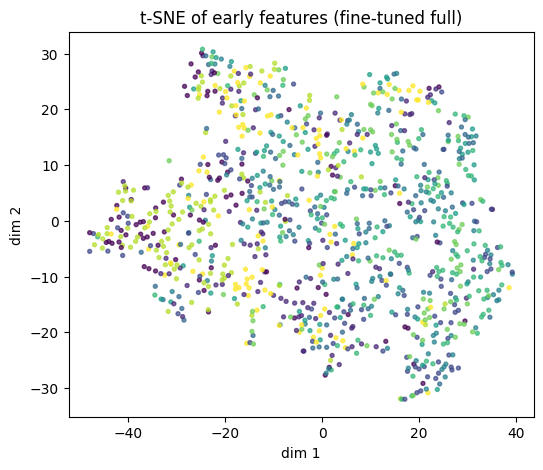

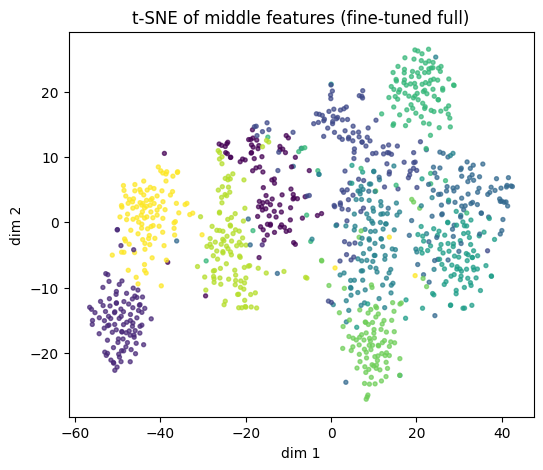

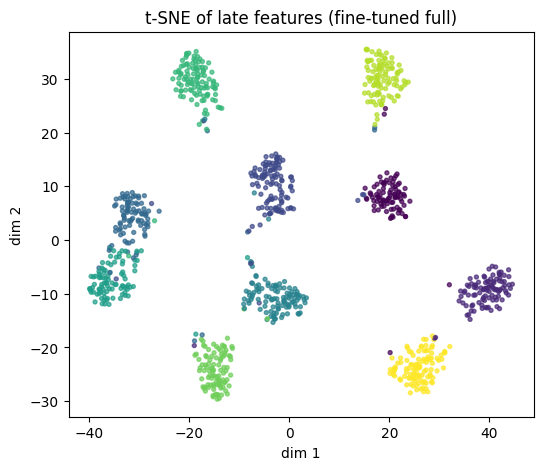

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


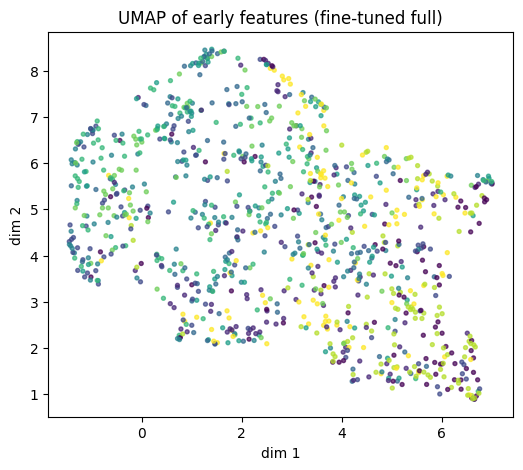

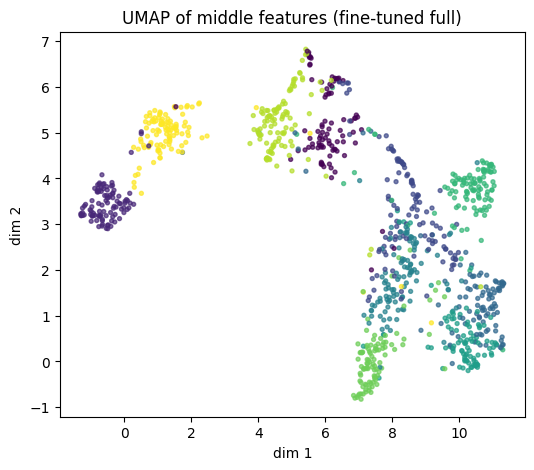

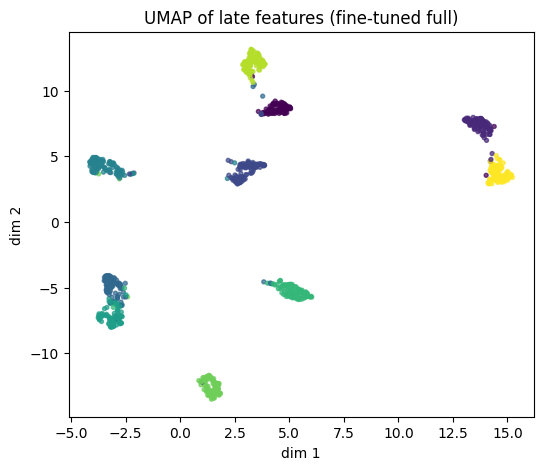

In [10]:
# Visualize features after full fine-tuning

# Collect features from the fully fine-tuned model
print("\n== Visualizing features after full fine-tuning ==")
viz_feats_full, viz_labels_full = collect_features(ft_full, val_loader, max_batches=8)

# t-SNE for each level
for level in ["early","middle","late"]:
    Z = run_tsne(viz_feats_full[level], perp=30)
    plot_scatter(Z, viz_labels_full, f"t-SNE of {level} features (fine-tuned full)")

# Optional: UMAP
if HAVE_UMAP:
    reducer = umap.UMAP(n_components=2, random_state=42)
    for level in ["early","middle","late"]:
        Z = reducer.fit_transform(viz_feats_full[level])
        plot_scatter(Z, viz_labels_full, f"UMAP of {level} features (fine-tuned full)")
else:
    print("UMAP not installed — skipping.")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#setting device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
#Transformations for training and testing datasets

transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

In [ ]:
# Downloading and preparing data

train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(train_data, batch_size=8, shuffle=True)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(test_data, batch_size=8, shuffle=False)

In [ ]:
trainloader, testloader
print(f"trainloader: {len(train_data)}")
print(f"testloader: {len(test_data)}")

trainloader: 50000
testloader: 10000


In [ ]:
num_classes = train_data.classes
classes_to_idx = train_data.class_to_idx

In [ ]:
# checking dataset
print(f"printing some details of the dataset")
print(f"Shape of one image {train_data[0][0].shape}")
print(f"label of one image {train_data[0][1]}")
print(f"Total number of images {len(train_data)} \nTotal classes {num_classes} \nMapping of classes to indices {classes_to_idx}")
print(f"Total classes {len(train_data.classes)}")

printing some details of the dataset
Shape of one image torch.Size([3, 224, 224])
label of one image 6
Total number of images 50000 
Total classes ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 
Mapping of classes to indices {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Total classes 10


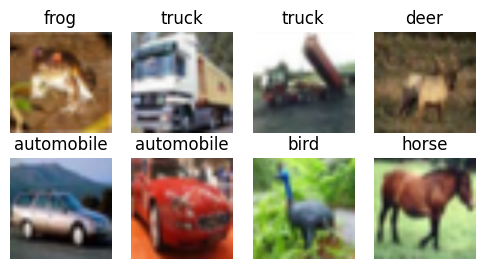

In [ ]:
# Visualizing some images from data
plt.figure(figsize=(6,3))
for i in range(8):
    plt.subplot(2,4,i+1)
    image = train_data[i][0].permute(1, 2, 0)
    image = image.numpy()
    image_data_uint8 = (image * 255).astype('uint8')

    label = train_data[i][1]
    plt.imshow(image)
    plt.title(num_classes[label])
    plt.axis('off')
plt.show()

In [ ]:
#loading Pre-Trained ResNet-152 and replacing Classification Head

model = torchvision.models.resnet152(weights="IMAGENET1K_V2")
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

In [ ]:
#freezing all layers except classification Head

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

#Loss and Optimizer Functions

CELoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [ ]:
#Training

def train_model(model, trainloader, optimizer, CELoss):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        y_pred = model(images)
        loss = CELoss(y_pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  #current loss * no of images in batch to accumulate total loss across all samples in epoch
        _, predicted = y_pred.max(1)
        correct += predicted.eq(labels).sum().item()
        total += y_pred.size(0)

    return running_loss / total, 100. * correct / total

In [ ]:
#Testing/Evaluation

def test_model(model, testloader, CELoss):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.inference_mode():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = CELoss(y_pred, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = y_pred.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, 100 * correct / total

In [ ]:
#Running Training for 10 Epochs

import tqdm
from timeit import default_timer as timer
start_time = timer()
epochs = 10
for epoch in tqdm.tqdm(range(epochs)):
    start_time = timer()
    train_loss, train_acc = train_model(model, trainloader, optimizer, CELoss)
    val_loss, val_acc = test_model(model, testloader, CELoss)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f},"
    f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    end_time = timer()
    print(f"Epoch time: {end_time - start_time:.2f} seconds")



 10%|█         | 1/10 [10:00<1:30:05, 600.64s/it]

Epoch: 1, Train Loss: 0.7327, Train Acc: 76.0060,Val Loss: 0.5853, Val Acc: 82.1400
Epoch time: 600.64 seconds


 20%|██        | 2/10 [20:03<1:20:17, 602.13s/it]

Epoch: 2, Train Loss: 0.6185, Train Acc: 79.2920,Val Loss: 0.5207, Val Acc: 82.9900
Epoch time: 603.17 seconds


 30%|███       | 3/10 [30:06<1:10:18, 602.59s/it]

Epoch: 3, Train Loss: 0.5990, Train Acc: 79.9920,Val Loss: 0.5827, Val Acc: 82.6700
Epoch time: 603.14 seconds


 40%|████      | 4/10 [40:10<1:00:17, 602.91s/it]

Epoch: 4, Train Loss: 0.5855, Train Acc: 80.2260,Val Loss: 0.5199, Val Acc: 82.8500
Epoch time: 603.40 seconds


 50%|█████     | 5/10 [50:12<50:13, 602.70s/it]  

Epoch: 5, Train Loss: 0.5792, Train Acc: 80.6000,Val Loss: 0.5095, Val Acc: 83.8400
Epoch time: 602.32 seconds


 60%|██████    | 6/10 [1:00:15<40:10, 602.71s/it]

Epoch: 6, Train Loss: 0.5746, Train Acc: 80.8220,Val Loss: 0.5005, Val Acc: 83.4000
Epoch time: 602.74 seconds


 70%|███████   | 7/10 [1:10:18<30:08, 602.91s/it]

Epoch: 7, Train Loss: 0.5746, Train Acc: 80.6760,Val Loss: 0.4972, Val Acc: 83.6800
Epoch time: 603.32 seconds


 80%|████████  | 8/10 [1:20:21<20:05, 602.78s/it]

Epoch: 8, Train Loss: 0.5725, Train Acc: 80.8760,Val Loss: 0.6280, Val Acc: 81.8600
Epoch time: 602.50 seconds


 90%|█████████ | 9/10 [1:30:23<10:02, 602.56s/it]

Epoch: 9, Train Loss: 0.5675, Train Acc: 81.1620,Val Loss: 0.5210, Val Acc: 83.1600
Epoch time: 602.06 seconds


100%|██████████| 10/10 [1:40:25<00:00, 602.58s/it]

Epoch: 10, Train Loss: 0.5695, Train Acc: 80.9760,Val Loss: 0.5654, Val Acc: 83.1400
Epoch time: 602.45 seconds


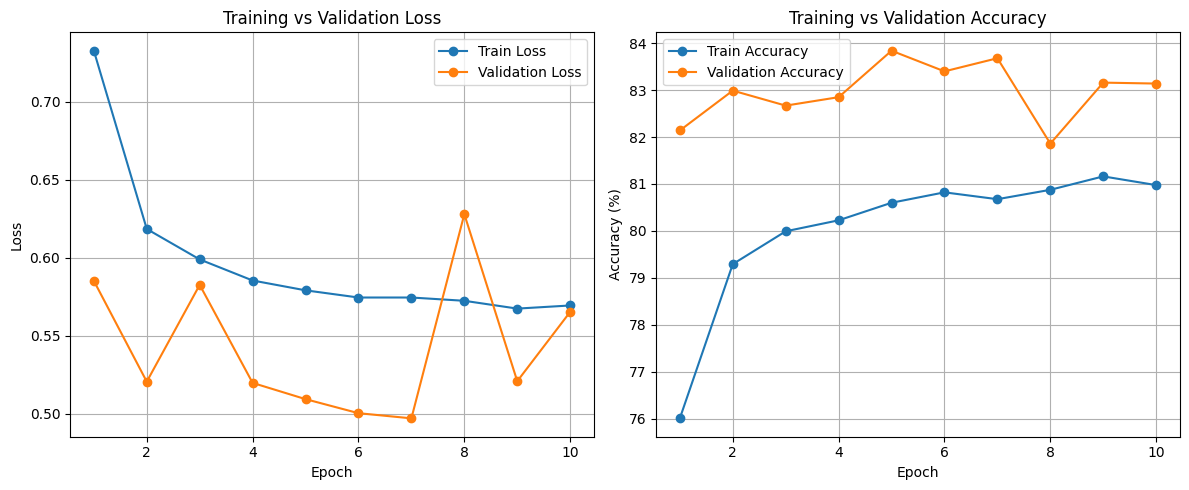

In [ ]:
import matplotlib.pyplot as plt

# Extracted from your logs
train_loss = [0.7327, 0.6185, 0.5990, 0.5855, 0.5792, 0.5746, 0.5746, 0.5725, 0.5675, 0.5695]
val_loss   = [0.5853, 0.5207, 0.5827, 0.5199, 0.5095, 0.5005, 0.4972, 0.6280, 0.5210, 0.5654]

train_acc  = [76.0060, 79.2920, 79.9920, 80.2260, 80.6000, 80.8220, 80.6760, 80.8760, 81.1620, 80.9760]
val_acc    = [82.1400, 82.9900, 82.6700, 82.8500, 83.8400, 83.4000, 83.6800, 81.8600, 83.1600, 83.1400]

epochs = range(1, 11)

# Plot losses
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'o-', label="Train Loss")
plt.plot(epochs, val_loss, 'o-', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'o-', label="Train Accuracy")
plt.plot(epochs, val_acc, 'o-', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# using Normalization on Training and Testind data to check how accuracy changes

transform_train_v2 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test_v2 = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [ ]:
# Downloading and preparing data

train_data_v2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train_v2)
trainloader_v2 = DataLoader(train_data_v2, batch_size=8, shuffle=True)

test_data_v2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test_v2)
testloader_v2 = DataLoader(test_data_v2, batch_size=8, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [ ]:
trainloader_v2, testloader_v2
print(f"trainloader: {len(train_data_v2)}")
print(f"testloader: {len(test_data_v2)}")

trainloader: 50000
testloader: 10000


In [ ]:
#loading Pre-Trained ResNet-152 and replacing Classification Head

model_v2 = torchvision.models.resnet152(weights="IMAGENET1K_V2")
num_features = model_v2.fc.in_features
model_v2.fc = nn.Linear(num_features, 10)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:02<00:00, 117MB/s] 


In [ ]:
#freezing all layers except classification Head

for param in model_v2.parameters():
    param.requires_grad = False
for param in model_v2.fc.parameters():
    param.requires_grad = True

model_v2 = model_v2.to(device)

#Loss and Optimizer Functions

CELoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v2.fc.parameters(), lr=1e-3)

In [ ]:
#Running Training for 10 Epochs

import tqdm
from timeit import default_timer as timer
start_time = timer()
epochs = 10
for epoch in tqdm.tqdm(range(epochs)):
    start_time = timer()
    train_loss, train_acc = train_model(model_v2, trainloader_v2, optimizer, CELoss)
    val_loss, val_acc = test_model(model_v2, testloader_v2, CELoss)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f},"
    f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    end_time = timer()
    print(f"Epoch time: {end_time - start_time:.2f} seconds")



 10%|█         | 1/10 [10:06<1:30:59, 606.63s/it]

Epoch: 1, Train Loss: 0.7344, Train Acc: 75.6260,Val Loss: 0.4965, Val Acc: 83.9700
Epoch time: 606.63 seconds


 20%|██        | 2/10 [20:12<1:20:49, 606.21s/it]

Epoch: 2, Train Loss: 0.6266, Train Acc: 78.9920,Val Loss: 0.5559, Val Acc: 81.8300
Epoch time: 605.90 seconds


 30%|███       | 3/10 [30:18<1:10:42, 606.01s/it]

Epoch: 3, Train Loss: 0.6078, Train Acc: 79.6420,Val Loss: 0.5076, Val Acc: 82.9400
Epoch time: 605.78 seconds


 40%|████      | 4/10 [40:24<1:00:36, 606.08s/it]

Epoch: 4, Train Loss: 0.5886, Train Acc: 80.3180,Val Loss: 0.4936, Val Acc: 83.7300
Epoch time: 606.19 seconds


 50%|█████     | 5/10 [50:30<50:30, 606.06s/it]  

Epoch: 5, Train Loss: 0.5883, Train Acc: 80.2860,Val Loss: 0.4884, Val Acc: 83.9300
Epoch time: 606.01 seconds


 60%|██████    | 6/10 [1:00:35<40:23, 605.77s/it]

Epoch: 6, Train Loss: 0.5865, Train Acc: 80.5360,Val Loss: 0.4982, Val Acc: 83.7600
Epoch time: 605.22 seconds


 70%|███████   | 7/10 [1:10:41<30:17, 605.69s/it]

Epoch: 7, Train Loss: 0.5809, Train Acc: 80.9080,Val Loss: 0.5343, Val Acc: 82.5600
Epoch time: 605.52 seconds


 80%|████████  | 8/10 [1:20:45<20:10, 605.30s/it]

Epoch: 8, Train Loss: 0.5821, Train Acc: 80.7240,Val Loss: 0.4882, Val Acc: 83.8500
Epoch time: 604.47 seconds


 90%|█████████ | 9/10 [1:30:52<10:05, 605.63s/it]

Epoch: 9, Train Loss: 0.5791, Train Acc: 80.6960,Val Loss: 0.5228, Val Acc: 82.8800
Epoch time: 606.34 seconds


100%|██████████| 10/10 [1:40:56<00:00, 605.64s/it]

Epoch: 10, Train Loss: 0.5721, Train Acc: 80.9440,Val Loss: 0.5058, Val Acc: 83.2900
Epoch time: 604.34 seconds


In [ ]:
torch.save(model_v2)